# Assignment 2: Language Modelling (TA: Navreet Kaur)

The goal of this assignment is to model Indian first names using character-level language models.

You'll have to add your code wherever you see the comment `# ADD YOUR CODE HERE`. Please make a copy of this assignment, and you can use Google Colab notebooks to work on this. Later, you can download this notebook as a python file and submit it as per the following instructions.

**Important Note**: Whenever you add your code, please enclose your code block within two comments `# BEGIN CODE` and `# END CODE` to indicate the start and end of your code.
Example:

```
def model():

    data = get_dataloader() # this is defined by us

    # ADD YOUR CODE HERE

    # BEGIN CODE

    run_training() # this is written by you

    generate_names() # this is written by you

    # END CODE

```

## Submission Instructions

Note that your assignment will be based on the results obtained by functions implemented by you. Do not change the print statements having `EVALUATION` as they are used for auto-evaluation.

You'd need to submit the following files:

  * Save this `.ipynb` to your drive, complete the required code blocks and run the notebook.

  * After completing this assignment, download the notebook as`.py`. Name it as `SAPname_SRno_assignment2.py`, where `SAPname` refers to your name as per SAP record, and `SRno` refers to the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would name it as `Twyla_Linda_15329_assignment2.py`.

  *   The files associated with FNN and RNN models i.e. `model.pt`, `vocab.pt` and `loss.json` will be downloaded and saved in folders with names `fnn` and `rnn` respectively, and these will be contained within folder `SAPname_SRno`. Zip this folder along with the `.py` file, save it as `SAPname_SRno_assigment2` and upload on MS Teams. The directory can be summarised as follows:

```
SAPname_SRno_assigment2
│   SAPname_SRno_assignment2.py  
│
└───SAPname_SRno
│   │
│   └───fnn
│   │   │   model.pt
│   │   │   vocab.pt
│   │   │   loss.json
│   │
│   └───rnn
│       │   model.pt
│       │   vocab.pt
│       │   loss.json

```

Because submissions are auto-graded, please ensure that the naming of the files is consistent with the instructions.

## Broad Outline

In this assignment, we will implement different types of language models for modeling Indian names. There are clealry patterns in Indian names that models could learn, and we start modeling those using n-gram models, then move to neural n-gram and RNN models.


**Marks Distribution:**
- Unigram: 5
- Bigram: 15
- Trigram: 10
- Neural N-gram LM: 30
- RNN LM: 40



# Read and Preprocess Data

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

Please note that we may change the contents of the following four files when we rerun your code, so please make sure that your solution is not specifically engineered to just these names.

In [ ]:
# Download the training and validation datasets
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv"
!wget -O valid_data.csv "https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv"

# Download the text for evaluation
!wget -O eval_prefixes.txt "https://drive.google.com/uc?export=download&id=1tuRLJXLd2VcDaWENr8JTZMcjFlwyRo60"
!wget -O eval_sequences.txt "https://drive.google.com/uc?export=download&id=1kjPAR04UTKmdtV-FJ9SmDlotkt-IKM3b"

--2024-02-24 08:33:48--  https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv
Resolving docs.google.com (docs.google.com)... 142.251.120.102, 142.251.120.138, 142.251.120.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.120.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_data.csv’

train_data.csv          [ <=>                ]  71.07K  --.-KB/s    in 0.005s  

2024-02-24 08:33:48 (13.5 MB/s) - ‘train_data.csv’ saved [72776]

--2024-02-24 08:33:48--  https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv
Resolving docs.google.com (docs.google.com)... 142.251.120.102, 142.251.120.138, 142.251.120.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.120.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv

In [ ]:
## Please do not change anything in this code block.

def read_dataframe(ds_type):
    """
    Args:
        ds_type [str] :  dataset type (train or valid)

    Returns:
        df [pandas dataframe]
    """

    df = pd.read_csv(f"/content/{ds_type}_data.csv", header=0, index_col=0)
    df = df[~df['Name'].isna()]
    df['Name'] = df['Name'].astype(str)
    return df

# Load the training and validation datasets
train_data = read_dataframe("train")
validation_data = read_dataframe("valid")

# Read files containing prefixes and character sequences for evaluation
with open('eval_prefixes.txt', 'r') as file:
    eval_prefixes = []
    for line in file:
        eval_prefixes.append(line.strip().split(" "))

with open('eval_sequences.txt', 'r') as file:
    eval_sequences = []
    for line in file:
        eval_sequences.append(line.strip().split(" "))

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4539
Length of validation data: 1297


In [ ]:
## Please do not change anything in this code block.

START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens
vocab_from_ascii = True

def build_vocab(names):
    """
    Builds a vocabulary given a list of names

    Args:
        names [list[str]]: list of names

    Returns:
        vocab [torchtext.vocab]: vocabulary based on the names

    """

    if vocab_from_ascii:
        char_counts = {chr(i):i for i in range(128)}
    else:
        char_counts = Counter("".join(names))

    vocab = build_vocab_from_iterator(
                    char_counts,
                    specials=[UNK, START, END], #adding special tokens to the vocabulary
                    min_freq=1
                )
    vocab.set_default_index(vocab[UNK])
    return vocab


def tokenize_name(name):
    """
    Tokenise the name i.e. break a name into list of characters

    Args:
        name [str]: name to be tokenized

    Returns:
        list of characters
    """

    return list(str(name))


def process_data_for_input(data_iter, vocab):
    """
    Processes data for input: Breaks names into characters,
    converts out of vocabulary tokens to UNK and
    appends END token at the end of every name

    Args:
        data_iter: data iterator consisting of names
        vocab: vocabulary

    Returns:
        data_iter [list[list[str]]]: list of names, where each name is a
                                list of characters and is appended with
                                START and END tokens

    """

    vocab_set = set(vocab.get_itos())
    # convert Out Of Vocabulary (OOV) tokens to UNK tokens
    data_iter = [[char if char in vocab_set else UNK
                        for char in tokenize_name(name)] for name in data_iter]
    data_iter = [[START] + name + [END] for name in data_iter]

    return data_iter


def get_tokenised_text_and_vocab(ds_type, vocab=None):
    """
    Reads input data, tokenizes it, builds vocabulary (if unspecified)
    and outputs tokenised list of names (which in turn is a list of characters)

    Args:
        ds_type [str]: Type of the dataset (e.g., train, validation, test)
        vocab [torchtext.vocab]: vocabulary;
                                 If vocab is None, the function will
                                 build the vocabulary from input text.
                                 If vocab is provided, it will tokenize name
                                 according to the vocab, replacing any tokens
                                 not part of the vocab with UNK token.

    Returns:
        data_iter: data iterator for tokenized names
        vocab: vocabulary

    """

    # read the 'Name' column of the dataframe
    if ds_type=='train':
        data_iter = train_data['Name']
    elif ds_type=='valid':
        data_iter = validation_data['Name']
    else:
        data_iter = test_data['Name']

    # build vocab from input data, if vocab is unspecified
    if vocab is None:
        vocab = build_vocab(data_iter)

    # convert OOV chars to UNK, append START and END token to each name
    data_iter = process_data_for_input(data_iter, vocab)

    return data_iter, vocab

Let's look at some examples from the training set

In [ ]:
# Look at some random examples from the training set
examples = ", ".join(random.sample(list(train_data['Name']), 5))
f"Examples from the training set: {examples}"

'Examples from the training set: mohad, ratul, munder, rakesh, nikhad'

# Module 1: N-gram Language Modelling

Load and preprocess the data for n-gram models

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# ADD YOUR CODE HERE

MAX_NAME_LENGTH = 10 # maximum length of names for generation

In [ ]:
# Get data iterator and build vocabulary from input text

train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

131



Now it's time to implement an [n-gram language model](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

One edge case you will need to handle is that you don't have $n-1$ prior characters at the beginning of the text.  One way to do this is by appending the `START` token $n-1$ times at the start of the name, when implementing an $n$-gram model. You may choose whichever method you like to handle this case as long as you produce a valid probability distribution (one that sums to one).

**Generating names**

To generate from a language model, we can sample one char at a time conditioning on the chars we have generated so far.

In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k chars or sharpening the distribution with a temperature.  You can read more about sampling from a language model in [this](https://arxiv.org/pdf/1904.09751.pdf) paper.


We will now implement N-gram models with $N=1$ (unigram), $N=2$ (bigram), and $N=3$ (trigram).

**Utility Functions**

Implement the utility functions `get_unigram_counts`, `get_bigram_counts` and `get_trigram_counts`. You can use these functions while implementing n-gram models.

In [ ]:
def get_unigram_counts(corpus):
    """
    Given a corpus, calculates the unigram counts for each character in the corpus

    Args:
        corpus [list[list[str]]]: list of tokenized characters. Text is appended with END token.

    Returns:
        unigram_counts [dict [key: char, value: count]]:
            dictionary of unigram counts for each character in the corpus
        Example:
        > unigram_counts["c1"] = 5
    """
    # ADD YOUR CODE HERE

    # BEGIN CODE
    count_unigram = defaultdict(int)

    for names_in_corp in corpus:
      if names_in_corp[0]==START:names_in_corp = names_in_corp[1:]
      for i in range(len(names_in_corp)):count_unigram[names_in_corp[i]]+=1
    # END CODE

    return count_unigram

In [ ]:
def get_bigram_counts(corpus):
    """
    Given a corpus, calculates the bigram counts for each bigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case whhere beginning of the name
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        bigram_counts [dict[dict]]:
            nested dictionary of bigram counts for each bigram in the corpus
        Example:
        > bigram_counts["c1"]["c2"] = 5
        here bigram_counts["c1"]["c2"] represents P("c2"|"c1")
        P["c1"]["c2"] means P[char_i = "c2"|char_{i-1} = "c1"]
    """

    # ADD YOUR CODE HERE

    # BEGIN CODE
    count_bigram = defaultdict(lambda :defaultdict(int))

    for name_in_corp in corpus:
      for i in range(len(name_in_corp)-1):count_bigram[name_in_corp[i]][name_in_corp[i+1]]+=1
    # END CODE


    return count_bigram

In [ ]:
def get_trigram_counts(corpus):
    """
    Given a corpus, calculates the trigram counts for each trigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case where beginning of the text
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        trigram_counts [dict[dict[dict]]]:
            nested dictionary for each trigram in the corpus
        Example:
        > trigram_counts["c1"]["c2"]["c3"] = 5
        P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]

    """
    # ADD YOUR CODE HERE

    # BEGIN CODE
    trigram_counts = defaultdict(lambda:defaultdict(lambda:defaultdict(int)))

    for name_in_corp in corpus:
      name_in_corp = [START]+name_in_corp
      for i in range(len(name_in_corp)-2):trigram_counts[name_in_corp[i]][name_in_corp[i+1]][name_in_corp[i+2]]+=1
    # END CODE


    return trigram_counts

In [ ]:
"""
Implementation of the n-gram language models.
All other n-gram models (unigram, bigram, etc.) would follow the same skeleton.
"""

class NGramLanguageModel(object):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            -
        """
        self.train_text = train_text
        self.vocab_size = len(vocab)
        # Compute n-gram counts based on the provided train_text
        self.ngram_counts = self._compute_ngram_counts(train_text)
        return
    #Defined by me
    #BEGIN CODE
    def _compute_ngram_counts(self, corpus):
        """
        Compute n-gram counts for the given corpus.

        Args:
            corpus [list of list]: list of tokenised names

        Returns:
            ngram_counts [dict]: nested dictionary containing n-gram counts
        """
        ngram_counts = defaultdict(Counter)
        for name in corpus:
            # Pad the beginning of the name with START tokens if necessary
            padded_name = [START] * (self.n - 1) + name
            # Iterate over the n-grams and update the counts
            for i in range(self.n - 1, len(padded_name)):
                ngram = tuple(padded_name[i - self.n + 1:i + 1])
                ngram_counts[ngram[:-1]].update([ngram[-1]])
        return ngram_counts
    #END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["c1"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
                for N=3 (trigram); dict[dict[dict]]
                    > P["c1"]["c2"]["c3"] = 0.0001
                    P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]
        """
        #BEGIN CODE
        # Compute probabilities based on n-gram counts
        # Pseudocode: P(c_i|c_{i-n+1}...c_{i-1}) = Count(c_{i-n+1}...c_{i}) / Count(c_{i-n+1}...c_{i-1})
        probabilities = defaultdict(dict)
        for ngram, counts in self.ngram_counts.items():
            prefix = ngram[:-1]
            total_count = sum(counts.values())
            for char, count in counts.items():
                probabilities[prefix][char] = count / total_count
        return probabilities

        #End CODE


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the language model

        Args:
            name [list]: list of tokens

        Returns:
            log_prob [float]: Log probability of the given name
        """
        #BEGIN CODE
        log_prob = 0.0
        probabilities = self.get_next_char_probabilities()
        # Compute the log probability of the name using the probabilities
        for i in range(self.n - 1, len(name)):
            prefix = tuple(name[i - self.n + 1:i])
            char = name[i]
            if prefix in probabilities and char in probabilities[prefix]:
                log_prob += math.log(probabilities[prefix][char])
            else:
                # Handle unknown characters or n-grams
                log_prob += float('-inf')
        return log_prob
        #END CODE


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity [float]: perplexity of the given text
        """
        #BEGIN CODE
        # Calculate perplexity using the log probability of the text
        log_prob_sum = sum(self.get_name_log_probability(name) for name in text)
        perplexity = math.exp(-log_prob_sum / len(text))
        return perplexity
        #END CODE


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.
        You may stop the generation when n tokens have been generated,
        or when you encounter the END token.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            names [list[str]]: list of generated names
        """
        #BEGIN CODE
        generated_names = []
        probabilities = self.get_next_char_probabilities()
        for _ in range(k):
            name = list(prefix) if prefix else []
            for _ in range(n):
                if len(name) >= n:
                    break
                # Sample the next character based on the prefix and probabilities
                next_char = random.choices(list(probabilities.get(tuple(name[-self.n + 1:]), {}).keys()),
                                           list(probabilities.get(tuple(name[-self.n + 1:]), {}).values()))[0]
                if next_char == END:
                    break
                name.append(next_char)
            generated_names.append("".join(name))
        return generated_names
        #END CODE

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        #BEGIN CODE
        probabilities = self.get_next_char_probabilities()
        prefix = tuple(sequence[-self.n + 1:])
        if prefix in probabilities:
            return sorted(probabilities[prefix].keys(), key=lambda char: -probabilities[prefix][char])[:k]
        else:
            return []
        #END CODE

In [ ]:
## Please do not change anything in this code block.

def check_validity(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1 or is_neural:

        is_valid = validate_probability_distribution(model.get_next_char_probabilities().values())
        if not is_valid:
            return is_valid

    elif ngram==2:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            is_valid = validate_probability_distribution(list(P[char1].values()))
            if not is_valid:
                return is_valid

    elif ngram==3:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            for char2 in P[char1].keys():
                is_valid = validate_probability_distribution(list(P[char1][char2].values()))
                if not is_valid:
                    return is_valid
    else:
        print("Enter a valid number for ngram")

    return True


def validate_probability_distribution(probs):
    """
    Checks if probs is a valid probability distribution
    """
    if not min(probs) >= 0:
        print("Negative value in probabilities")
        return False
    elif not max(probs) <= 1 + 1e-8:
        print("Value larger than 1 in probabilities")
        return False
    elif not abs(sum(probs)-1) < 1e-4:
        print("probabilities do not sum to 1")
        return False
    return True


def eval_ngram_model(model, ngram, ds, ds_name, eval_prefixes, eval_sequences, num_names=5, is_neural=False):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model=model, ngram=ngram, is_neural=is_neural)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of {ngram}-gram on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names))
    print(f'EVALUATION {ngram}-gram generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION {ngram}-gram generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION {ngram}-gram top most likely chars after {sequence} are {most_likely_chars}")

## 1.1 Unigram

In [ ]:
"""
Implementaion of a Unigram Model without smoothing
"""

class UnigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        self.unigram_counts = get_unigram_counts(train_text)
        # END CODE


    #Implemented by me
    def _compute_ngram_counts(self, corpus):
        """
        Compute unigram counts for the given corpus.

        Args:
            corpus [list of list]: list of tokenised names

        Returns:
            unigram_counts [dict]: dictionary containing unigram counts
        """
        unigram_counts = Counter()
        for name in corpus:
            unigram_counts.update(name)
        return unigram_counts
    #End of own implementation
    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        next_char_probabilities = defaultdict(float)

        total = sum(self.unigram_counts.values())
        for key,val in self.unigram_counts.items():
          next_char_probabilities[key]= val/total
        self.next_char_probabilities = next_char_probabilities.copy()
        # END CODE

        return next_char_probabilities



    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        name_log_probability = 0
        if name[0]==START:name=name[1:]
        for char in name:name_log_probability+=np.log(self.next_char_probabilities[char])
        # END CODE


        return name_log_probability



    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        entropy = 0
        n = 0
        for name in text:
          n+= len(name)-1 if name[0]==START else len(name)
          entropy-=self.get_name_log_probability(name)
        entropy/=n
        perplexity = np.exp(entropy)
        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        names = []
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        charctrs,probablty = zip(*self.next_char_probabilities.items())
        for j in range(k):
          length_of_name = 0
          name=str()
          while length_of_name<n:
            C = charctrs[np.random.choice(len(charctrs),p=probablty)]
            if C==END:break
            name+=C
            length_of_name+=1
          names.append(name)
        # END CODE

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        # BEGIN CODE
        charctrs_probablty_pairs = sorted(self.next_char_probabilities.items(),key=lambda x:x[1],reverse=True)
        most_likely_chars = [C for C,p in charctrs_probablty_pairs[:k]]
        # END CODE
        return most_likely_chars

### Eval

**Note**: For models without smoothing, you may observe perplexity as `inf` if the validation or test set contains characters not seen in the train set
However, this should not happen for models where you implement smoothing.

In [ ]:
## Please do not change anything in this code block.

unigram_model = UnigramModel(train_text)

# Check the perplexity of the unigram model on the train set
print('unigram train perplexity:',
      unigram_model.get_perplexity(train_text))

unigram train perplexity: 16.08557368746752


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: inf
EVALUATION 1-gram generated names are kspuudmais, asynmabe, uarhbhnina, mhbktknniu, rkmr
EVALUATION 1-gram generated names with prefix <s><s>sh are laioanajmf, jna, u, kihatnnmcr, hs
EVALUATION 1-gram top most likely chars after <s><s>aa are a, </s>, i, n, h


<ipython-input-13-00984265e878>:77: RuntimeWarning: divide by zero encountered in log
  for char in name:name_log_probability+=np.log(self.next_char_probabilities[char])


### Smoothing

Implement a smoothed version of the unigram model. You may extend the `UnigramModel` class and re-use some of the functions.  For unigram model, you should implement Add-1 smoothing.

You may refer to the lecture slides or [3.5 Smoothing](https://web.stanford.edu/~jurafsky/slp3/3.pdf) for details on different smoothing technqiues.


In [ ]:
"""
Implementation of unigram model with Add-1 smoothing.

"""
class SmoothedUnigramModel(UnigramModel):

    def __init__(self, train_text):
        super().__init__(train_text)

    # You should override ONLY those functions
    # which calculate probability of a unigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in UnigramModel
    # to calculate unigram probabilities.

    # Implement Laplace or Add-1 smoothing for the unigram model

    # ADD YOUR CODE HERE
    # BEGIN CODE
    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary with Add-1 smoothing

        Returns:
            key: char, value: probability
        """

        next_char_probabilities = dict()
        Voca = len(vocab.get_stoi().keys())-1
        totals = sum(self.unigram_counts.values())
        for kys in vocab.get_stoi().keys():
          if kys==START:continue
          next_char_probabilities[kys]= (self.unigram_counts[kys]+1)/(totals+Voca)
        self.next_char_probabilities = next_char_probabilities.copy()


        return next_char_probabilities
    # END CODE

In [ ]:
## Please do not change anything in this code block.

smoothed_unigram_model = SmoothedUnigramModel(train_text)

# Check the perplexity of the smoothed unigram model on the train set
print('smoothed unigram train perplexity:',
      smoothed_unigram_model.get_perplexity(train_text))

smoothed unigram train perplexity: 16.135561100014737


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences,  num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: 26.06354887749268
EVALUATION 1-gram generated names are ani, bsatmnaahi, , fbiakrna, ur
EVALUATION 1-gram generated names with prefix <s><s>sh are bi, ibeadiynba, jm, astsmy0saa, syaupnensh
EVALUATION 1-gram top most likely chars after <s><s>aa are a, </s>, i, n, h


In [ ]:
# Release models we don't need any more.
del unigram_model
del smoothed_unigram_model

## 1.2 Bigram

In [ ]:
"""
Implementation of a Bigram Model.
"""

class BigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        self.bigram_counts = get_bigram_counts(train_text)
        # END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        next_char_probabilities = defaultdict(lambda:defaultdict(float))
        for k1 in self.bigram_counts.keys():
          total = sum(self.bigram_counts[k1].values())
          for k2,counts in self.bigram_counts[k1].items():
            next_char_probabilities[k1][k2] = counts/total
        self.next_char_probabilities = next_char_probabilities
        # END CODE
        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        name_log_probability=0
        for i in range(len(name)-1):
          name_log_probability+=np.log(self.next_char_probabilities[name[i]][name[i+1]])
        # END CODE

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE


        # BEGIN CODE
        ENTRPY = 0
        n = 0
        for name_in_corp in text:
          n+= len(name_in_corp)-1 if name_in_corp[0]==START else len(name_in_corp)
          ENTRPY-=self.get_name_log_probability(name_in_corp)
        ENTRPY/=n
        perplexity = np.exp(ENTRPY)
        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        names = []
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        for i in range(k):
          length_of_name = 0
          name=[START]
          while length_of_name<n:
            charctrs,probablty = zip(*self.next_char_probabilities[name[-1]].items())
            C = charctrs[np.random.choice(len(charctrs),p=probablty)]
            if C==END:break
            name.append(C)
            length_of_name+=1
          names.append("".join(name[1:]))
        # END CODE

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE

        # BEGIN CODE
        charctr_probablty_pairs = sorted(self.next_char_probabilities[sequence[-1]].items(),key=lambda x:x[1],reverse=True)
        most_likely_chars = [c for c,p in charctr_probablty_pairs[:k]]
        # END CODE

        return most_likely_chars

### Eval

In [ ]:
## Please do not change anything in this code block.

bigram_model = BigramModel(train_text)

# check the perplexity of the bigram model on training data
print('bigram train perplexity:',
      bigram_model.get_perplexity(train_text))

bigram train perplexity: 10.130805242739347


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: inf
EVALUATION 2-gram generated names are bn, jarm, karukaa, sheniteela, k
EVALUATION 2-gram generated names with prefix <s><s>sh are ankhidriyu, a, r, rala, uleshaiarn
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, r, m, l


<ipython-input-20-8c525904e5f8>:62: RuntimeWarning: divide by zero encountered in log
  name_log_probability+=np.log(self.next_char_probabilities[name[i]][name[i+1]])


### Smoothing

Implement a smoothed version of the bigram model. You may extend the `BigramModel` class and re-use some of the functions.

You will implement the following smoothing techniques:
-  Laplace or add-k smoothing
- Interpolation


**Laplace or Add-k smoothing**
- what is the effect of changing `k`?

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

BIGRAM_LAPLACE_K = 0.65 # value of k for add-k or Laplac smoothing in bigram models

In [ ]:
"""
Implementation of a bigram model with laplace or add-k smoothing.

"""

class LaplaceSmoothedBigramModel(BigramModel):
    # This class extends BigramModel.

    def __init__(self, train_text, k):
        super().__init__(train_text)
        self.k = k # specify k for smoothing

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE
    # BEGIN CODE
    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """
        Voca = len(vocab.get_stoi().keys())-1
        next_char_probabilities = dict()
        for k1 in vocab.get_stoi().keys():
            if k1==END:continue
            next_char_probabilities[k1]={}
            total = sum(self.bigram_counts[k1].values()) if k1 in self.bigram_counts.keys() else 0
            for k2 in vocab.get_stoi().keys():
                if k2==START:continue
                next_char_probabilities[k1][k2]=(self.bigram_counts[k1][k2]+self.k)/(total+self.k*Voca)
        self.next_char_probabilities = next_char_probabilities

        return next_char_probabilities
    # END CODE

In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = LaplaceSmoothedBigramModel(train_text, k=BIGRAM_LAPLACE_K)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 10.613033366292239


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 17.97197378112287
EVALUATION 2-gram generated names are mkaudrnish, maat, hadnde, r, bam
EVALUATION 2-gram generated names with prefix <s><s>sh are sonasud, ranetarsh, meek, ja\/)%o, bee>pegin
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, r, m, l


**Interpolation**
- what are good values for `lambdas` in interpolation?

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

BIGRAM_LAMBDAS = (0.85, 0.15) # lambdas for interpolation smoothing in bigram models

In [ ]:
"""
Implementation of a bigram model with interpolation smoothing
"""

class InterpolationSmoothedBigramModel(BigramModel):

    def __init__(self, train_text, lambdas):
        super().__init__(train_text)
        self.lambda_1, self.lambda_2 = lambdas

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE
    # BEGIN CODE
        self.unigram_counts = get_unigram_counts(train_text)
    #END CODE

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary with Add-1 smoothing

        Returns:
            key: char, value: probability
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        uni_char_probabilities = dict()
        total = sum(self.unigram_counts.values())
        for k in vocab.get_stoi().keys():
          if k==START:continue
          uni_char_probabilities[k]= (self.unigram_counts[k])/(total)


        bi_char_probabilities = dict()
        next_char_probabilities = dict()
        Voca = len(vocab.get_stoi().keys())-1
        for k1 in vocab.get_stoi().keys():
            if k1==END:continue
            bi_char_probabilities[k1]={}
            next_char_probabilities[k1]={}
            total = sum(self.bigram_counts[k1].values()) if k1 in self.bigram_counts.keys() else 0
            for k2 in vocab.get_stoi().keys():
                if k2==START:continue
                bi_char_probabilities[k1][k2]=(self.bigram_counts[k1][k2])/(total) if total!=0 else 1/Voca
                next_char_probabilities[k1][k2]=0.95*self.lambda_1*bi_char_probabilities[k1][k2]+0.95*self.lambda_2*uni_char_probabilities[k2]+0.05*(self.lambda_1+self.lambda_2)*(1/Voca)
        self.next_char_probabilities = next_char_probabilities.copy()

        # END CODE

        return next_char_probabilities


In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = InterpolationSmoothedBigramModel(train_text, lambdas=BIGRAM_LAMBDAS)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 10.85918069870875


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 16.714068582558482
EVALUATION 2-gram generated names are kkhaad, bai, nnt ll&, chpno, K}dulr
EVALUATION 2-gram generated names with prefix <s><s>sh are patataF^3u, masamarcha, , araju, aJub
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, r, m, l


In [ ]:
# Release models we don't need any more.
del bigram_model
del smoothed_bigram_model

## 1.3 Trigram (smoothed)

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

TRIGRAM_LAMBDAS = (0.45, 0.4, 0.15) # lambdas for interpolation smoothing in trigram models

In [ ]:
"""
Implementaion of a Trigram Model with interpolation smoothing.
"""

class TrigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        #BEGIN CODE
        self.trigram_counts = get_trigram_counts(train_text)
        self.bigram_counts = get_bigram_counts(train_text)
        self.unigram_counts = get_unigram_counts(train_text)
        self.lambda_1,self.lambda_2,self.lambda_3 = TRIGRAM_LAMBDAS
        #END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["a"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (corresponding to P(b|a))
                for N=3 (trigram); dict[dict[dict]]
                    > P["a"]["b"]["c"] = 0.0001 (corresponding to P(c|ab))
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        uni_char_probabilities = dict()
        total = sum(self.unigram_counts.values())
        for k in vocab.get_stoi().keys():
          if k==START:continue
          uni_char_probabilities[k]= (self.unigram_counts[k])/(total)


        bi_char_probabilities = dict()
        Voca = len(vocab.get_stoi().keys())-1
        for k1 in vocab.get_stoi().keys():
            if k1==END:continue
            bi_char_probabilities[k1]={}
            total = sum(self.bigram_counts[k1].values()) if k1 in self.bigram_counts.keys() else 0
            for k2 in vocab.get_stoi().keys():
                if k2==START:continue
                bi_char_probabilities[k1][k2]=(self.bigram_counts[k1][k2])/(total) if total!=0 else 1/Voca


        tri_char_probabilities = dict()
        next_char_probabilities = dict()
        for k1 in vocab.get_stoi().keys():
            if k1==END:continue
            tri_char_probabilities[k1]={}
            next_char_probabilities[k1]={}
            for k2 in vocab.get_stoi().keys():
              if k2==END:continue
              tri_char_probabilities[k1][k2]={}
              next_char_probabilities[k1][k2]={}
              total = sum(self.trigram_counts[k1][k2].values()) if (k1 in self.bigram_counts.keys()) and (k2 in self.bigram_counts[k1].keys()) else 0
              for k3 in vocab.get_stoi().keys():
                  if k3==START:continue
                  tri_char_probabilities[k1][k2][k3]=(self.trigram_counts[k1][k2][k3])/(total) if total!=0 else 1/Voca
                  next_char_probabilities[k1][k2][k3]=0.95*self.lambda_1*tri_char_probabilities[k1][k2][k3]+0.95*self.lambda_2*bi_char_probabilities[k2][k3]+0.95*self.lambda_3*uni_char_probabilities[k3]+0.05*(self.lambda_1+self.lambda_2+self.lambda_3)*(1/Voca)
        self.next_char_probabilities = next_char_probabilities.copy()
        # END CODE

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        name_log_probability=0
        name = [START]+name
        for i in range(len(name)-2):
          name_log_probability+=np.log(self.next_char_probabilities[name[i]][name[i+1]][name[i+2]])
        # END CODE

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        ENTRPY = 0
        n = 0
        for name in text:
          n+= len(name)-1 if name[0]==START else len(name)
          ENTRPY-=self.get_name_log_probability(name)
        ENTRPY/=n
        perplexity = np.exp(ENTRPY)
        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        names = []
        if not hasattr(self,"next_char_probabilities"):self.get_next_char_probabilities()
        for i in range(k):
          length_of_name = 0
          name=[START,START]
          while length_of_name<n:
            charctrs,probablty = zip(*self.next_char_probabilities[name[-2]][name[-1]].items())
            C = charctrs[np.random.choice(len(charctrs),p=probablty)]
            if C==END:break
            name.append(C)
            length_of_name+=1
          names.append("".join(name[2:]))
        # END CODE

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        # BEGIN CODE

        most_likely_chars = [C for C,probablty in sorted(self.next_char_probabilities[sequence[-2]][sequence[-1]].items(),key=lambda x:x[1],reverse=True)[:k]]
        # END CODE

        return most_likely_chars

#### Eval

In [ ]:
## Please do not change anything in this code block.

trigram_model = TrigramModel(train_text)

print('trigram train perplexity:',
      trigram_model.get_perplexity(train_text))

trigram train perplexity: 9.747689052383466


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=trigram_model, ngram=3, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 3-gram on validation perplexity: 15.67228756213587
EVALUATION 3-gram generated names are )Ugur, eshadakari, ^lay, ni, nika
EVALUATION 3-gram generated names with prefix <s><s>sh are p, baru, nu, 0#O<unk> P;"o, 4<nlsameet
EVALUATION 3-gram top most likely chars after <s><s>aa are n, </s>, s, r, m


In [ ]:
# Release models we don't need any more.
del trigram_model

# Module 2: Neural Language Modelling

## 2.1 Neural N-gram Language Model

For this part of the assignment, you should use the GPU (you can do this by changing the runtime of this notebook).

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` chars and outputs a distribution over the next char.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using [PyTorch's data loaders](https://pytorch.org/docs/stable/data.html)

In [ ]:
# Import the necessary libraries

import math
import time
import random
import os, sys
import json
from functools import partial

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
## Please do not change anything in this code block.

def collate_ngram(batch, text_pipeline):
    """
    Converts the text in the batch to tokens
    and maps the tokens to indices in the vocab.
    The text in the batch is a list of ngrams
    i.e. if N=3, then text contains 3 tokens in a list
    and batch is a list of such texts.

    Returns:
        batch_input [pytorch tensor]:
            input for n-gram model with size batch_size*(ngram-1)
        batch_output [pytorch tensor]:
            output for n-gram model with size batch_size
    """

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        # last token is the output, and
        #  pervious ngram-1 tokens are inputs
        output = token_id_sequence.pop()
        input = token_id_sequence
        batch_input.append(input)
        batch_output.append(output)

    # Convert lists to PyTorch tensors and moves to the gpu (if using)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    if USE_CUDA:
        batch_input = batch_input.cuda()
        batch_output = batch_output.cuda()

    return batch_input, batch_output


def get_dataloader(input_text, vocab, ngram, batch_size, shuffle):
    """
    Creates a dataloader for the n-gram model which
    takes in a list of list of tokens, appends the START token
    at the starting of each text, and converts text into ngrams.

    Example: For a trigram model, the list of characters are
        ["n", "a", "v", "r"]
    will be converted into lists
        ["n", "a", "v"], ["a", "v", "r"]

    For each ngram, first ngram-1 tokens are input and last token
    is the output. Each token is converted into a index in the vocab.
    The dataloader generates a batch of input, output pairs as
    pytorch tensors.


    Args:
        input_text [list[list[str]]]: list of list of tokens
        vocab [torchtext.vocab]: vocabulary of the corpus
    """

    ngram_sequences = []
    for text in input_text:
        if text[0] == START:
            text = [START]*(N_GRAM_LENGTH-2) + text
        else:
            text = [START]*(N_GRAM_LENGTH-1) + text

        # Create training pairs for each char in the text
        for idx in range(len(text) - ngram + 1):
            ngram_sequence = text[idx : (idx + ngram)]
            ngram_sequences.append(ngram_sequence)

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_ngram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """

    dataloader = DataLoader(
        ngram_sequences,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

#### FNN Implementation

**Feed-forward Neural Language Modelling**

Like the n-gram LM, the feedforward neural LM approximates the probability of a char given the entire prior context $P(w_t|w_{1:t−1})$ by approximating based on the $N-1$ previous chars:
$$P(w_t|w_1,...,w_{t−1}) ≈ P(w_t|w_{t−N+1},...,w_{t−1})$$


Implement the FNN LM given in this paper: [Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

The architecture of the FNN can be described by the equation and figure:

$$y = b + W x + U \text t \text a \text n \text h (d + H x)$$

- $x$ is of size $(ngram-1)*m$ where $m$ is the size embedding dimensions
- $y$ is of size $V*1$ where $V$ is the vocabulary size

![FNN_LM](https://drive.google.com/uc?id=1aQhkXjWelHfiBfmBQV3z5TjHFNMtqtzT)


**Some tips**:
- embed the chars with dimension $m$ (example, $60$), then flatten into a single embedding for  $n-1$  chars (with size  $(n-1)*m$ )
- you can use Adam or Stochastic Gradient Descent (SGD) for optimising the cross entropy loss
- If you are using SGD, you may want to use momentum, and a learning rate scheduler
- do early stopping based on validation set loss or perplexity

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.

In [ ]:
"""
Implemenation of a PyTorch Module that holds the neural network for your model

"""
class FNN_LM(nn.Module):

    def __init__(self, vocab_size, emb_size, hid_size, ngram):
        super(FNN_LM, self).__init__()
        self.ngram = ngram

        # YOUR CODE HERE
        # BEGIN CODE
        self.emb_size = emb_size
        self.embedding_layer = nn.Embedding(vocab_size,emb_size)
        self.linear1 = nn.Linear((ngram-1)*emb_size,hid_size)
        self.linear2 = nn.Linear(hid_size,vocab_size,bias=False)
        self.linear3 = nn.Linear((ngram-1)*emb_size,vocab_size)
        # END CODE


    def forward(self, chars):
        """
        Args:
            chars: this is a tensor of inputs with shape [batch_size x ngram-1]

        Returns:
            logits: a tensor of log probabilities with shape [batch_size x vocab_size]

        """

        # YOUR CODE HERE
        # BEGIN CODE
        U = self.embedding_layer(chars).view(-1,(self.ngram-1)*self.emb_size)
        logits = self.linear3(U)+self.linear2(torch.tanh(self.linear1(U)))
        # END CODE
        return logits

**The following is the Trainer class for the FNN LM. Add your code for the `training` and `validation` loops.**

In [ ]:
from re import X
class NeuralNGramTrainer:
    """
    NeuralNGramTrainer wraps FNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to NeuralNGramTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        ngram,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.ngram = ngram
        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.val_loss_count = []
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE
        # FOR TRAINING & VALIDATION

        for epoch in range(self.epochs):
          self.model.train()
          self.train_epoch(self.train_dataloader)
          self.model.eval()
          self.valid_epoch(self.valid_dataloader)
          self.plot_losses()
          print("train_loss:",self.loss["train"][-1])
          print("validation_loss:",self.loss["val"][-1])


    def train_epoch(self,dl):
      for batch in dl:
        self.train_batch(batch)

    def valid_epoch(self,dl):
        val_loss = 0
        n =0
        for batch in dl:
          batch_len = len(batch)
          val_loss += batch_len*self.valid_batch(batch)
          n+=batch_len

        self.loss["val"].append(val_loss/n)
        self.val_loss_count.append(len(self.loss["train"])-1)

    def train_batch(self,batch):
        xbatch,ybatch = batch
        y_pred = self.model(xbatch)
        loss = self.criterion(y_pred,ybatch)
        loss.backward()
        self.loss["train"].append(loss.detach().clone().cpu().item())
        self.optimizer.step()
        if hasattr(self.optimizer,"sched"):self.optimizer.sched.step()
        self.optimizer.zero_grad()

    def valid_batch(self,batch):
        xb,yb = batch
        with torch.no_grad():
          y_pred = self.model(xb)
          loss = self.criterion(y_pred,yb)
        return loss.detach().clone().cpu().item()


    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.val_loss_count,self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show()


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        token_idntty =  torch.tensor([vocab[ct] for ct in [START]*(self.ngram-1)],dtype=torch.long).reshape(1,self.ngram-1)
        if self.use_cuda:token_idntty = token_idntty.cuda()
        self.model.eval()
        with torch.no_grad():
          probablty = torch.softmax(self.model(token_idntty),dim=1)[0]
        itos = vocab.get_itos()
        next_char_probabilities = dict()
        for i in range(len(probablty)):
          next_char_probabilities[itos[i]]=probablty[i]
        # END CODE

        return next_char_probabilities



    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()
        # BEGIN CODE
        self.model.eval()
        if prefix==None:prefix=[START]*(self.ngram-1)
        if len(prefix)!=self.ngram-1:prefix = [START]*(self.ngram-1-len(prefix))+prefix
        names = []
        itos = vocab.get_itos()
        for i in range(k):
          name = prefix.copy()
          name_length=0
          while name_length<n:
            token_idntty = torch.tensor([vocab[ct] for ct in name[-(self.ngram-1):]],dtype=torch.long).reshape(1,-1)
            if self.use_cuda:token_idntty = token_idntty.cuda()
            with torch.no_grad():
              probablty = torch.softmax(self.model(token_idntty),dim=1)[0]
            if self.use_cuda:probablty = probablty.cpu()
            probablty = probablty.numpy()
            C =  itos[np.random.choice(len(probablty),p=probablty)]
            if C==END:break
            name.append(C)
            name_length+=1
          names.append("".join(name))
        # END CODE

        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE

        # you may want to use the dataloader here
        # don't forget self.model.eval()
        # BEGIN CODE
        self.model.eval()
        dl = get_dataloader(text,vocab,self.ngram,256,False)
        ENTRPY,n = 0,0
        with torch.no_grad():
          for xbatch,ybatch in dl:

            probablty = torch.softmax(self.model(xbatch),dim=1)[range(len(xbatch)),ybatch.ravel()]
            if self.use_cuda:probablty=probablty.cpu()

            ENTRPY-=np.sum(np.log(probablty.numpy()))
            n+=len(xbatch)

        perplexity = np.exp(ENTRPY/n)


        # END CODE


        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE
        # don't forget self.model.eval()

        # BEGIN CODE
        self.model.eval()
        itos = vocab.get_itos()
        if len(sequence)!=self.ngram-1:sequence = [START]*(self.ngram-1-len(sequence))+sequence
        token_ids = torch.tensor([vocab[c] for c in sequence[-(self.ngram-1):]],dtype=torch.long).reshape(1,-1)
        if self.use_cuda:token_ids = token_ids.cuda()
        with torch.no_grad():

          probablty = torch.softmax(self.model(token_ids),dim=1)
          if self.use_cuda:probablty=probablty.cpu()
          probablty = probablty.numpy()
        most_likely_chars = [c for c,_ in sorted(zip(itos,list(probablty.ravel())),key=lambda x:x[1],reverse=True)[:k]]

        # END CODE

        return most_likely_chars

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 10 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

N_GRAM_LENGTH = 6 # The length of the n-gram (N_GRAM_LENGTH=3 for trigram)
EMB_SIZE = 50 # The size of the embedding
HID_SIZE = 128 # The size of the hidden layer
EPOCHS = 25
BATCH_SIZE = 2000
SHUFFLE = True # if dataset should be shuffled

GPU is available: True


In [ ]:
## Please do not change anything in this code block.

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# Load training and validation dataloaders
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

131


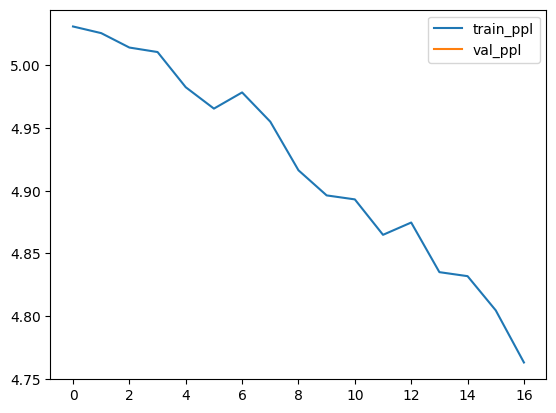

train_loss: 4.763192176818848
validation_loss: 4.82747220993042


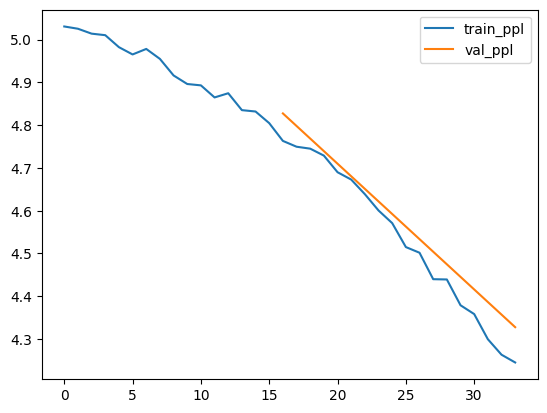

train_loss: 4.245092868804932
validation_loss: 4.32766170501709


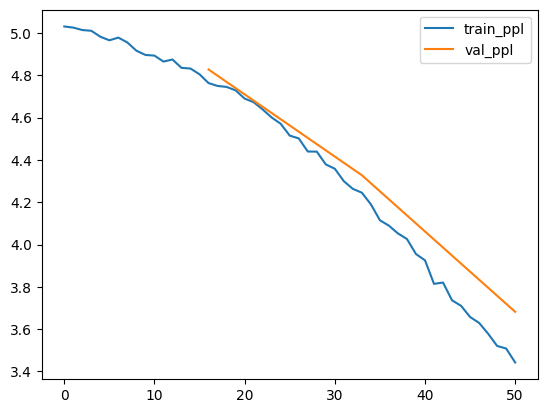

train_loss: 3.442582845687866
validation_loss: 3.6820146083831786


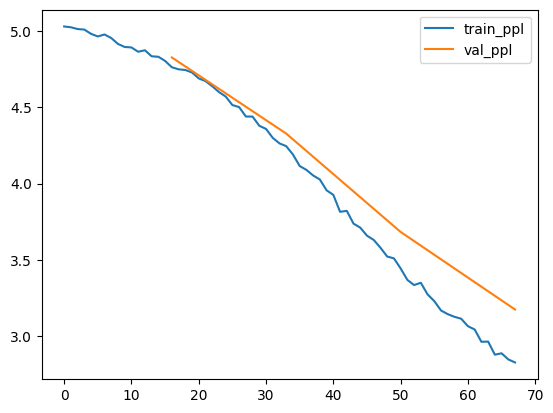

train_loss: 2.8252131938934326
validation_loss: 3.1728775978088377


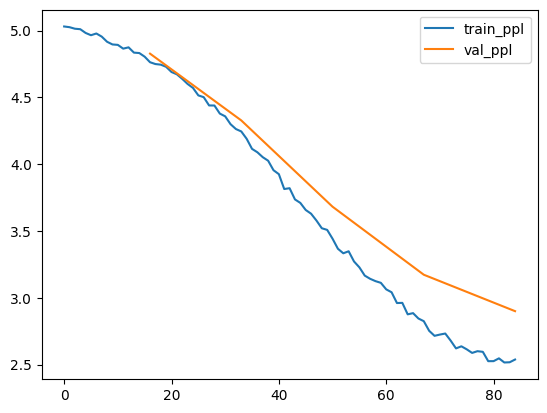

train_loss: 2.538182497024536
validation_loss: 2.90028338432312


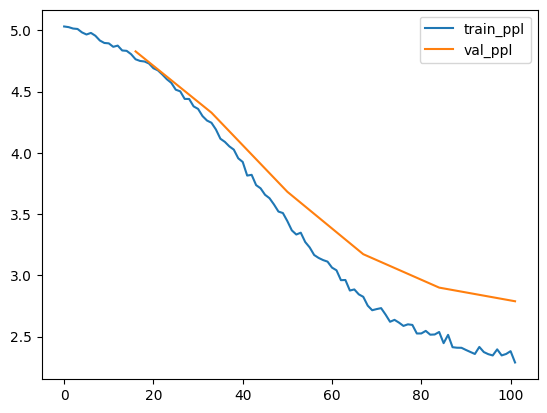

train_loss: 2.289421558380127
validation_loss: 2.7889069080352784


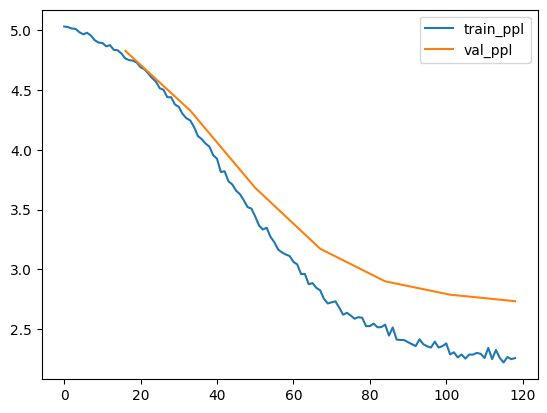

train_loss: 2.259016275405884
validation_loss: 2.734293794631958


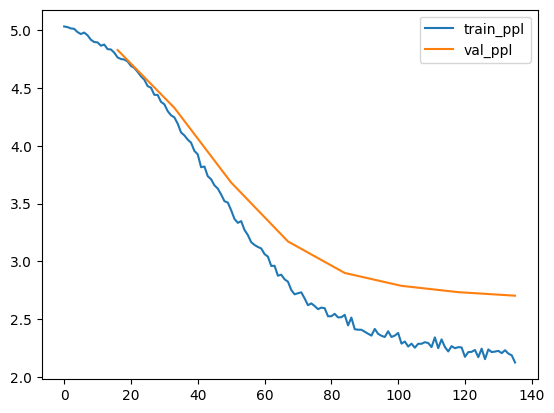

train_loss: 2.126530408859253
validation_loss: 2.7038105964660644


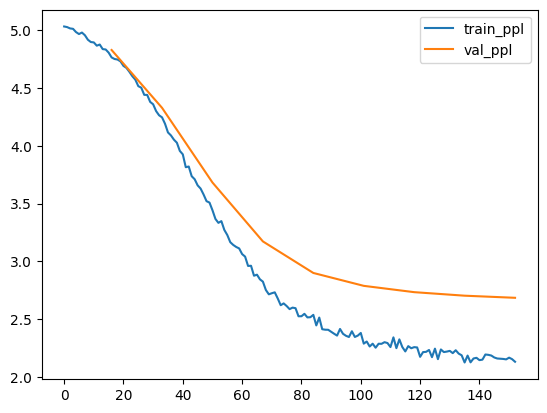

train_loss: 2.132866144180298
validation_loss: 2.685557222366333


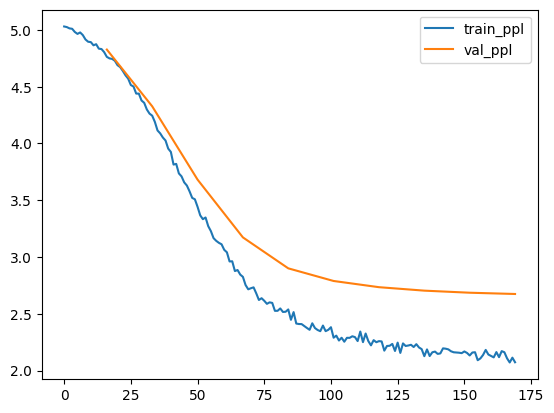

train_loss: 2.073090076446533
validation_loss: 2.6744375705718992


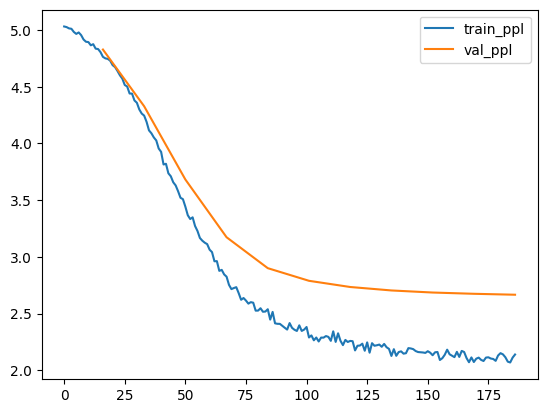

train_loss: 2.1391186714172363
validation_loss: 2.666160726547241


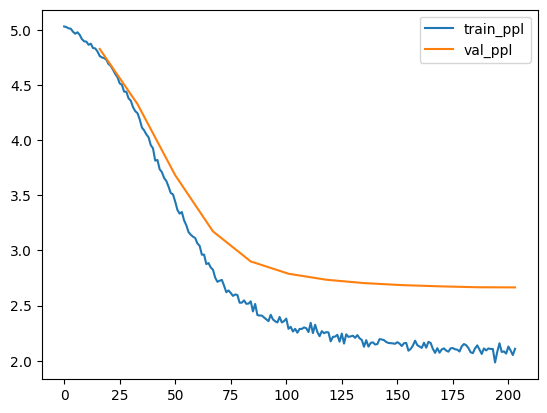

train_loss: 2.1081619262695312
validation_loss: 2.6646881103515625


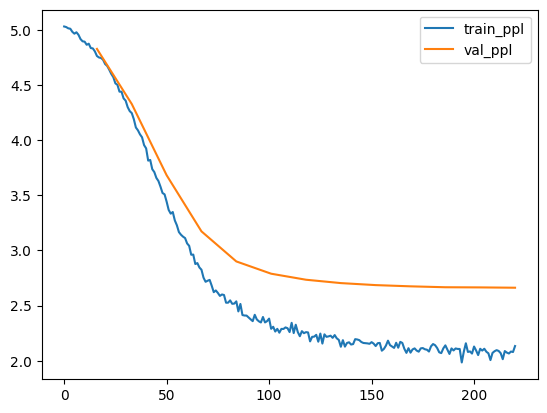

train_loss: 2.1330008506774902
validation_loss: 2.661831092834473


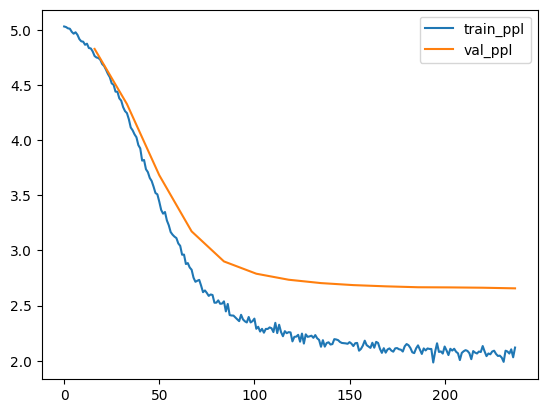

train_loss: 2.11922025680542
validation_loss: 2.656185674667358


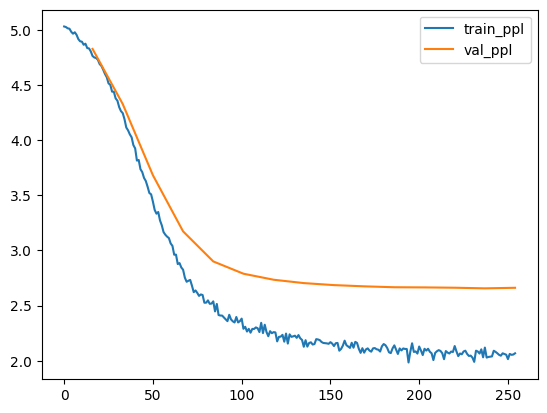

train_loss: 2.067044973373413
validation_loss: 2.661248207092285


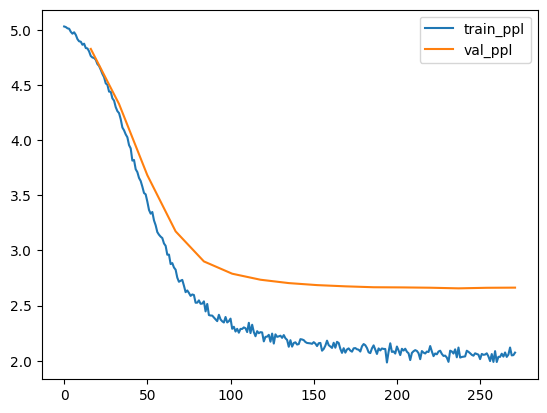

train_loss: 2.0733590126037598
validation_loss: 2.662626123428345


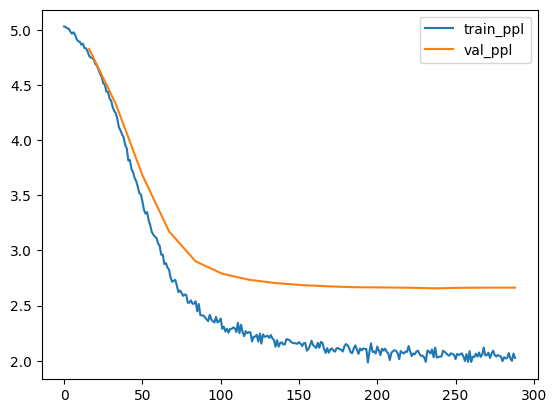

train_loss: 2.025150775909424
validation_loss: 2.6626216888427736


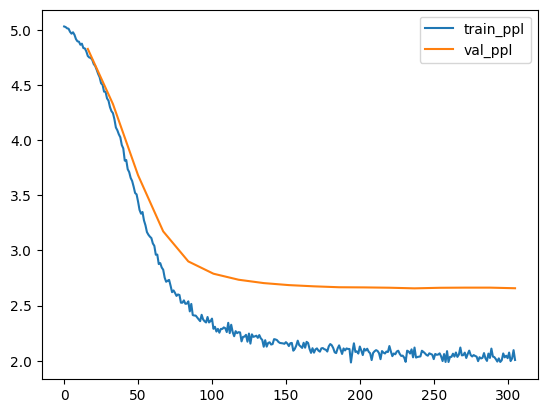

train_loss: 2.006762742996216
validation_loss: 2.657124423980713


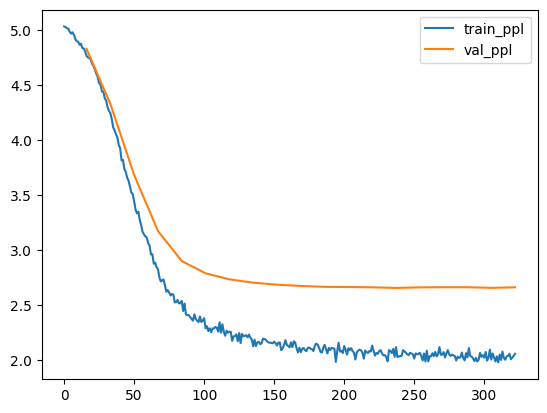

train_loss: 2.0574162006378174
validation_loss: 2.6617621898651125


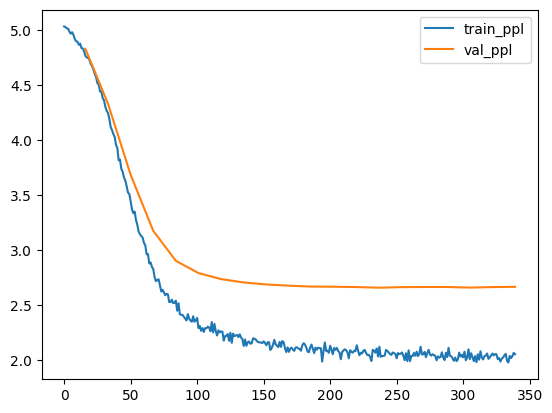

train_loss: 2.0510778427124023
validation_loss: 2.664162015914917


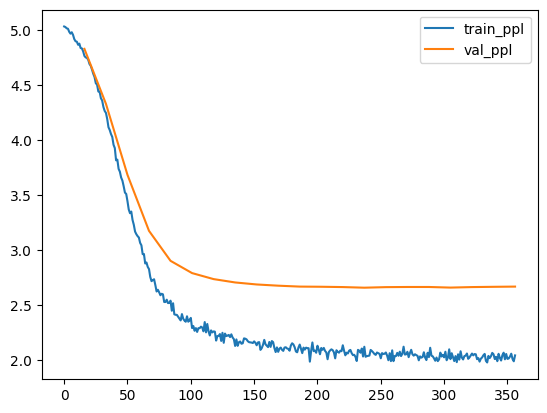

train_loss: 2.040644884109497
validation_loss: 2.6661577224731445


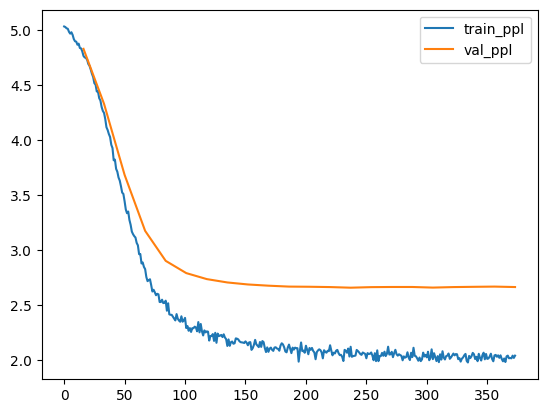

train_loss: 2.038557529449463
validation_loss: 2.6620787143707276


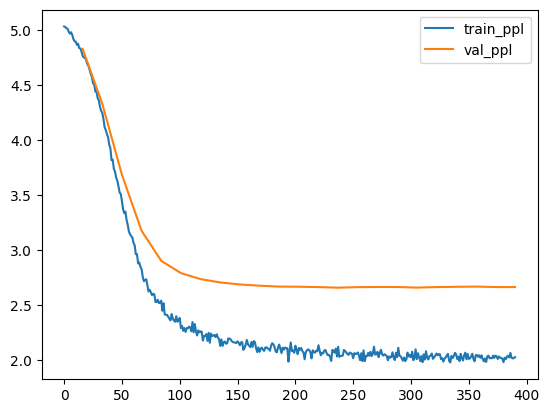

train_loss: 2.024287223815918
validation_loss: 2.6618517875671386


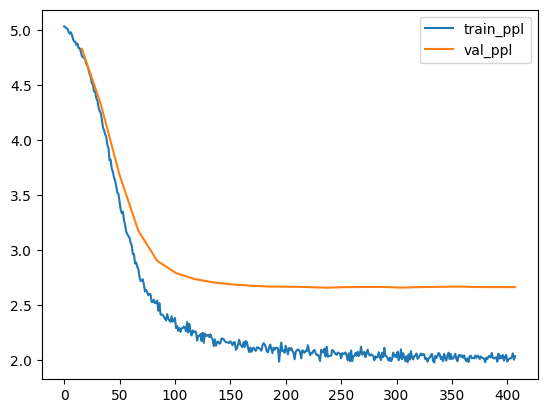

train_loss: 2.033921480178833
validation_loss: 2.6616787910461426


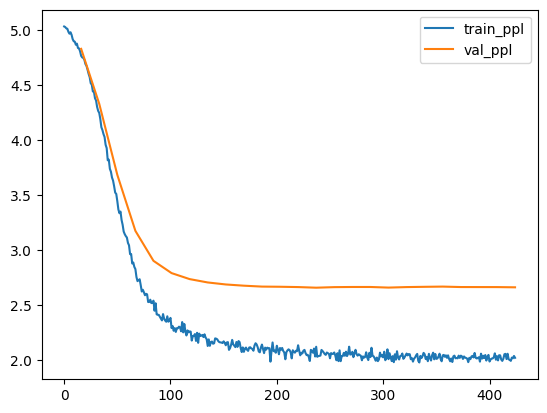

train_loss: 2.0187065601348877
validation_loss: 2.6596282005310057
Training finished.
Model artifacts saved to folder: Suvendu_Kar_22882/fnn


In [ ]:
# ADD YOUR CODE HERE

# This is the part where you should train your FNN_LM model

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialise the model, optimizer, learning rate scheduler (optional), and loss criteria
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

lr = 1*1e-3
weight_decay = 0.03
optimizer = optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay)
optimizer.sched = optim.lr_scheduler.OneCycleLR(optimizer,lr,EPOCHS*len(train_dataloader))
criterion = nn.functional.cross_entropy

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir='Suvendu_Kar_22882/fnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=model_dir,
        vocab=vocab)

# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

### Eval

In [ ]:
eval_ngram_model(trainer, ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

EVALUATION probability distribution is valid: True
EVALUATION of 6-gram on valid perplexity: 14.320505142884558
EVALUATION 6-gram generated names are <s><s><s><s><s>kauprna, <s><s><s><s><s>pambhan, <s><s><s><s><s>saana, <s><s><s><s><s>hantil, <s><s><s><s><s>reepu
EVALUATION 6-gram generated names with prefix <s><s>sh are <s><s><s>shabi, <s><s><s>shanish, <s><s><s>shbitha, <s><s><s>shkalila, <s><s><s>shabir
EVALUATION 6-gram top most likely chars after <s><s>aa are n, s, m, r, j


Load your saved model and generate a few names

In [ ]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = 'Suvendu_Kar_22882/fnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=None,
        criterion=None,
        train_dataloader=None,
        valid_dataloader=None,
        epochs=None,
        use_cuda=USE_CUDA,
        model_dir=None,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

<s>aashi, <s>aasha, <s>aashulnesha, <s>aashamsabidnds, <s>aasha


In [ ]:
# Release models we don't need any more.
del trainer
del model

## 2.2 Recurrent Neural Networks for Language Modelling

For this stage of the assignment, you will implement an RNN language model.

Some tips:
* use dropout
* use the same weights for the embedding layer and the pre-softmax layer
* train with Adam


In [ ]:
"""
Implemenation of a PyTorch Module that holds the RNN

"""
class RNN_LM(nn.Module):

    # you may change the input arguments for __init__
    def __init__(self,emb_dim,num_layers=1,dropout=0.0):
        super(RNN_LM, self).__init__()

        # YOUR CODE HERE
        # BEGIN CODE
        self.emb_layer = nn.Embedding(len(vocab),emb_dim)
        self.lstm = nn.LSTM(emb_dim,emb_dim,num_layers,batch_first=True,dropout=dropout)
        # END CODE

    def forward(self,X):
        """
          X is list of tensors which contains the token ids
          example:
            X=[torch.tensor([1,3,4]),torch.tensor([0,1])]
        """
        # YOUR CODE HERE
        # BEGIN CODE
        Y = []
        for x in X:
          x = self.emb_layer(x)
          h,_ = self.lstm(x[None])
          Y.append(h[0]@(self.emb_layer.weight.T))
        # END CODE

        return Y

In [ ]:
class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to RNNTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.val_loss_count = []
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()

    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE
        # FOR TRAINING & VALIDATION

        for epoch in range(self.epochs):
          self.model.train()
          self.train_epoch(self.train_dataloader)
          self.model.eval()
          self.valid_epoch(self.valid_dataloader)
          self.plot_losses()
          print("epoch number:",epoch)
          print("train_loss:",self.loss["train"][-1])
          print("validation_loss:",self.loss["val"][-1])



    def train_epoch(self,dl):
      for batch in dl:
        self.train_batch(batch)

    def valid_epoch(self,dl):
        val_loss = 0
        n =0
        for batch in dl:
          b = len(batch)
          val_loss += b*self.valid_batch(batch)
          n+=b

        self.loss["val"].append(val_loss/n)
        self.val_loss_count.append(len(self.loss["train"])-1)

    def train_batch(self,batch):
        xbatch,yb_list = batch
        y_pred_list = self.model(xbatch)
        loss = 0
        for y_pred,yb in zip(y_pred_list,yb_list):loss=loss+self.criterion(y_pred,yb)
        loss = loss/len(yb_list)
        loss.backward()
        self.loss["train"].append(loss.detach().clone().cpu().item())
        self.optimizer.step()
        if hasattr(self.optimizer,"sched"):self.optimizer.sched.step()
        self.optimizer.zero_grad()

    def valid_batch(self,batch):
        xbatch,yb_list = batch
        with torch.no_grad():
          y_pred_list = self.model(xbatch)
          loss = 0
          for y_pred,yb in zip(y_pred_list,yb_list):loss=loss+self.criterion(y_pred,yb)
          loss = loss/len(yb_list)
        return loss.detach().clone().cpu().item()


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.val_loss_count,self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show()


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        token_idntty =  torch.tensor([vocab[START]],dtype=torch.long)
        if self.use_cuda:token_idntty = token_idntty.cuda()
        token_idntty = [token_idntty]
        self.model.eval()
        with torch.no_grad():
          probablty = torch.softmax(self.model(token_idntty)[0],dim=1)[0]
        itos = vocab.get_itos()
        next_char_probabilities = dict()
        for i in range(len(probablty)):
          next_char_probabilities[itos[i]]=probablty[i]
        # END CODE

        return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()
        # BEGIN CODE
        self.model.eval()
        if prefix==None:prefix=[START]
        if prefix[0]!=START:prefix=[START]+prefix
        for i in range(len(prefix)):
          if prefix[i]!=START:
            prefix = prefix[i-1:].copy()
            break
        names = []
        itos = vocab.get_itos()
        for i in range(k):
          name = prefix.copy()
          name_length=0
          while name_length<n:
            token_ids = torch.tensor([vocab[c] for c in name],dtype=torch.long)
            if self.use_cuda:token_ids = token_ids.cuda()
            token_ids = [token_ids]
            with torch.no_grad():
              probs = torch.softmax(self.model(token_ids)[0][-1],dim=0)
            if self.use_cuda:probs = probs.cpu()
            probs = probs.numpy()
            c =  itos[np.random.choice(len(probs),p=probs)]
            if c==END:break
            name.append(c)
            name_length+=1
          names.append("".join(name))
        # END CODE

        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE

        # you may want to use the dataloader here
        # don't forget self.model.eval()
        # BEGIN CODE
        self.model.eval()
        dl = get_dataloader_for_rnn(text,vocab,1,False)
        ENTRPY,n = 0,0
        with torch.no_grad():
          for xbatch,yb_list in dl:
            yb=yb_list[0]

            probablty = torch.softmax(self.model(xbatch)[0],dim=1)[range(len(xbatch[0])),yb.ravel()]
            if self.use_cuda:probablty=probablty.cpu()
            probablty = probablty.numpy()
            ENTRPY-=np.sum(np.log(probablty))
            n+=len(xbatch[0])

        perplexity = np.exp(ENTRPY/n)


        # END CODE

        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()
        # BEGIN CODE
        self.model.eval()
        itos = vocab.get_itos()
        if sequence[0]!=START:sequence=[START]+sequence
        for i in range(len(sequence)):
          if sequence[i]!=START:
            sequence = sequence[i-1:].copy()
            break
        token_ids = torch.tensor([vocab[c] for c in sequence],dtype=torch.long)
        if self.use_cuda:token_ids = token_ids.cuda()
        token_ids = [token_ids]
        with torch.no_grad():

          probs = torch.softmax(self.model(token_ids)[0][-1],dim=0)
          if self.use_cuda:probs=probs.cpu()
          probs = probs.numpy()

        most_likely_chars = [c for c,_ in sorted(zip(itos,list(probs.ravel())),key=lambda x:x[1],reverse=True)[:k]]

        # END CODE

        return most_likely_chars

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 10 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

EPOCHS = 5
BATCH_SIZE = 96
SHUFFLE = True # if dataset should be shuffled

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# create the dataloaders for training and validation

# ADD YOUR CODE HERE

# BEGIN CODE
def collate_for_rnn(batch, text_pipeline):

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        input = token_id_sequence[:-1]
        output = token_id_sequence[1:]
        batch_output.append(torch.tensor(output,dtype=torch.long))
        batch_input.append(torch.tensor(input,dtype=torch.long))



    if USE_CUDA:
        batch_output = [x.cuda() for x in batch_output]
        batch_input = [x.cuda() for x in batch_input]


    return batch_input, batch_output


def get_dataloader_for_rnn(input_text, vocab,batch_size, shuffle):

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_for_rnn

    dataloader = DataLoader(
        input_text,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

train_dataloader = get_dataloader_for_rnn(train_text,vocab,BATCH_SIZE,SHUFFLE)
valid_dataloader = get_dataloader_for_rnn(validation_text,vocab,BATCH_SIZE,False)
# END CODE

GPU is available: True
131


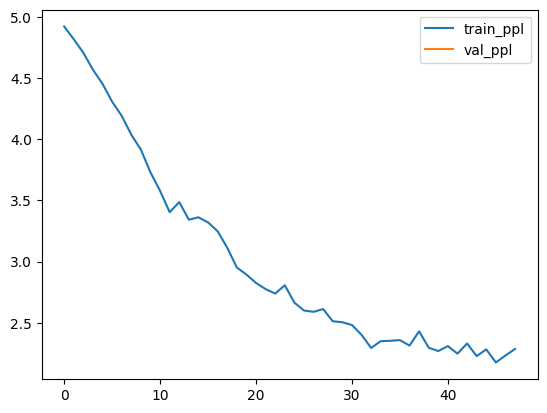

epoch number: 0
train_loss: 2.2866804599761963
validation_loss: 2.7067497798374722


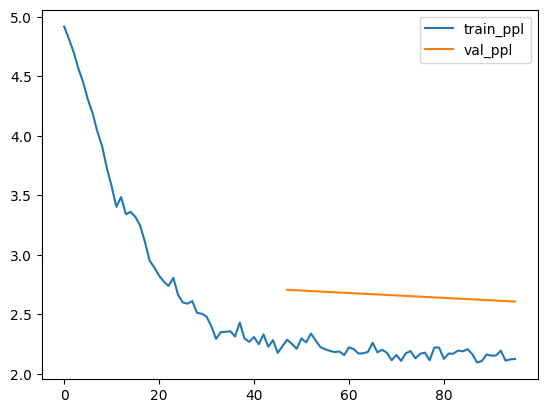

epoch number: 1
train_loss: 2.125472068786621
validation_loss: 2.6077968222754344


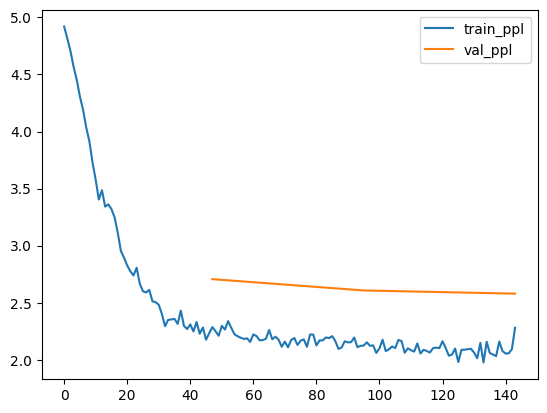

epoch number: 2
train_loss: 2.2812116146087646
validation_loss: 2.5797349895749773


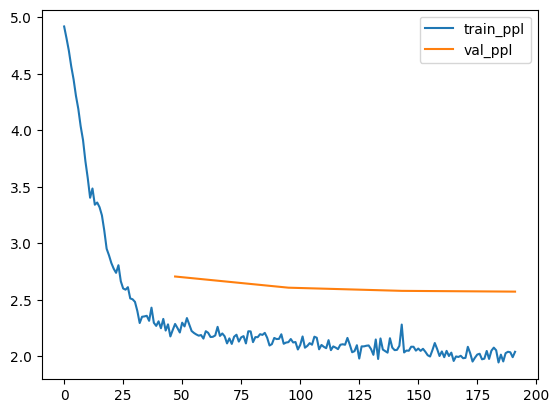

epoch number: 3
train_loss: 2.040053606033325
validation_loss: 2.5729033265795027


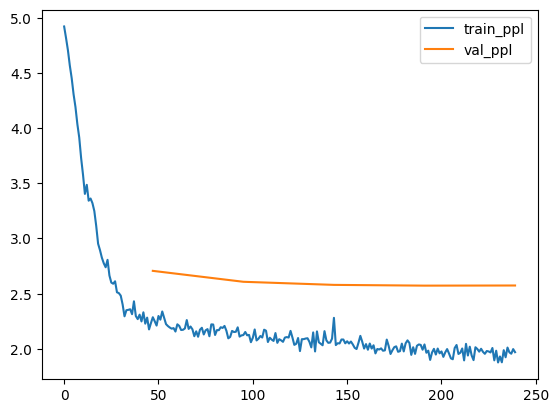

epoch number: 4
train_loss: 1.9702144861221313
validation_loss: 2.5741327660424367
Training finished.
Model artifacts saved to folder: Suvendu_Kar_22882/rnn


In [ ]:
# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialize the model
# you may want to pass arguments to RNN_LM based on your implementation
model = RNN_LM(128,2,0.3)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

# Initialise the optimizer, learning rate scheduler (optional), and loss criteria

lr = 0.01
weight_decay = 0.03
optimizer = optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay)
optimizer.sched = optim.lr_scheduler.OneCycleLR(optimizer,lr,EPOCHS*len(train_dataloader))
criterion = nn.functional.cross_entropy

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir='Suvendu_Kar_22882/rnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        vocab=vocab,
        model_dir=model_dir
        )

# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

### Eval

In [ ]:
## Please do not change anything in this code block.

def eval_rnn_model(model, ds, ds_name, eval_prefixes, eval_sequences, num_names=5):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model, 1, True)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of RNN on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH))
    print(f'EVALUATION RNN generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION RNN generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION RNN the top most likely chars after {sequence} are {most_likely_chars}")

In [ ]:
eval_rnn_model(trainer, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of RNN on valid perplexity: 12.631790494335826
EVALUATION RNN generated names are <s>purchad, <s>sarniya, <s>tarial, <s>hilu, <s>pratha
EVALUATION RNN generated names with prefix <s><s>sh are <s>shardeepal, <s>shad, <s>shiramaal, <s>shaksana, <s>shibi
EVALUATION RNN the top most likely chars after <s><s>aa are s, r, n, m, b


In [ ]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = 'Suvendu_Kar_22882/rnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=None,
        criterion=None,
        train_dataloader=None,
        valid_dataloader=None,
        epochs=None,
        use_cuda=USE_CUDA,
        model_dir=None,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

<s>aashan, <s>aashpal, <s>aasheela, <s>aashib, <s>aash


In [ ]:
# Release models we don't need any more.
del trainer
del model

# Congratulations!

You've reacehd the end of the assignment. Hope this was a pleasant and fun exercise!

Check the submission instructions mentioned at the begining of the notebook in order to submit your homework.
